In [3]:
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import keras, pickle, numpy as np
from keras.models import Model
from keras.layers import MaxPooling1D
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from scipy.sparse import csc_matrix
from gcn.operations import coarsen, perm_data, GraphConv

In [4]:
data_griewank = pickle.load(open("histogram_data/histogram-gng-mpl-es-griewank.out", "rb"))
data_rastrigin = pickle.load(open("histogram_data/histogram-gng-mpl-es-rastrigin.out", "rb"))
data_sphere = pickle.load(open("histogram_data/histogram-gng-mpl-es-sphere.out", "rb"))
data_ackley = pickle.load(open("histogram_data/histogram-gng-mpl-es-ackley.out", "rb"))

amat = pickle.load(open("model_data/100-3-model_gng-amat.out", "rb"))

In [5]:
X, y = [], []

for a,b,c,d in zip(data_ackley, data_griewank, data_rastrigin, data_sphere):
#for a,b,c,d in zip(data_boha, data_ellipt, data_rosen, data_schwefel):

    for elem in [a, b, c, d]:
        X.append(elem)
        
        #X.append(a[0]), X.append(b[0]), X.append(c[0]), X.append(d[0])
        #X.append(a[1]), X.append(b[1]), X.append(c[1]), X.append(d[1])
    y.append(0), y.append(1), y.append(2), y.append(3)

In [6]:
# Perform graph coarsening for the pooling operations
graphs, perms = coarsen(A=csc_matrix(amat), levels=4)
A = [g.A for g in graphs]

Layer 0: M_0 = |V| = 112 nodes (12 added),|E| = 514 edges
Layer 1: M_1 = |V| = 56 nodes (5 added),|E| = 272 edges
Layer 2: M_2 = |V| = 28 nodes (2 added),|E| = 129 edges
Layer 3: M_3 = |V| = 14 nodes (0 added),|E| = 57 edges
Layer 4: M_4 = |V| = 7 nodes (0 added),|E| = 19 edges


In [7]:
X_perm = [perm_data(x, perms) for x in X]
Xp = [xp.T for xp in X_perm]
#Xp = [xp.T for xp in X]

In [8]:
X_train, y_train = np.array(Xp), np.array(y)
#X_train, y_train = np.array(Xp[:3200]), np.array(y[:3200])
X_test, y_test = np.array(Xp[-800:]), np.array(y[-800:])

In [9]:
lb = LabelBinarizer()

Y_train = lb.fit_transform(y_train)
Y_train = lb.transform(y_train)
Y_test = lb.transform(y_test)

In [10]:
accs = []

data_shape = (np.shape(Xp)[1],2)
num_classes = 4

#for i in range(0,10):
in_x = Input(shape=data_shape)
x = GraphConv(filters=25, adjacency_matrix=A[0], input_features=2)(in_x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=4, padding='same')(x)
x = GraphConv(filters=16, adjacency_matrix=A[2], input_features=25)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=4, padding='same')(x)
x = Flatten()(x)
x = Dense(10)(x)
x = Activation('relu')(x)
x = Dense(50)(x)
x = Activation('relu')(x)
out_x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=in_x, outputs=out_x)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

h = model.fit(X_train, Y_train, epochs=1000, batch_size=250, verbose=0, validation_split=0.2)
#accs.append(h.history['val_acc'][-1])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 2)            0         
_________________________________________________________________
graph_conv_1 (GraphConv)     (None, 112, 25)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 112, 25)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 25)            0         
_________________________________________________________________
graph_conv_2 (GraphConv)     (None, 28, 16)            0         
_________________________________________________________________
activation_2 (Activation)    (None, 28, 16)            0         
_________________________________________________________________
max_

In [11]:
inter_output_model = Model(model.input, model.layers[9].output)

In [12]:
out = inter_output_model.predict(X_test)

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300)
tsne_pca_results = tsne.fit_transform(out).T

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x = tsne_pca_results

if (x.shape[0]==3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*x, c=y_test, alpha=0.5)
else:
    labels = ['Ackley','Griewank','Rastrigin','Sphere']
    #colors = [0,1,2,3]
    colors = ['purple','darkblue','green','gold']
    for i,l in enumerate(labels):
        plt.scatter([],[], c=[colors[i]], alpha=1, label=l)
    plt.scatter(*x, c=[y for y in y_test], alpha=.5)
    plt.legend(loc='upper right')
    plt.show()

<Figure size 640x480 with 1 Axes>

In [15]:
colors2 = ['blue', 'black', 'red', 'lime']

C:\Users\stfri\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


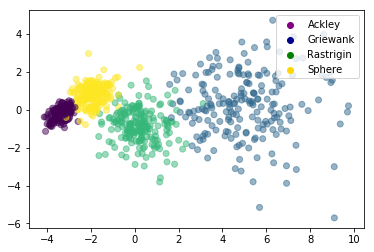

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda_x = lda.fit(out, y_test).transform(out).T

if(lda_x.shape[0]==3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # make the panes transparent
    #ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    for i,l in enumerate(labels):
        ax.scatter([],[], c=[colors2[i]], alpha=1, label=l)
    ax.scatter(*lda_x, c=[y for y in y_test], alpha=0.5)
    #plt.savefig("21-01-21-benchs-symmetric.pdf")
else:
    #labels = ['Bohachevsky','Elliptic','Rosenbrock','Schwefel']
    labels = ['Ackley','Griewank','Rastrigin','Sphere']
    #colors = [0,1,2,3]
    #colors = ['purple','darkblue','green','gold']
    colors = ['purple','darkblue','green','gold']
    for i,l in enumerate(labels):
        plt.scatter([],[], c=[colors[i]], alpha=1, label=l)
    plt.scatter(*lda_x, c=[y for y in y_test], alpha=.5)
    #plt.scatter(*lda_x, c=[colors[y] for y in y_test], alpha=.5)
    plt.legend(loc='upper right')
    #plt.savefig("21-01-21-benchs-symmetric-pop.pdf")
    plt.show()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


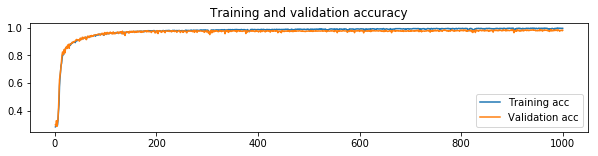

In [17]:
# list all data in history
print(h.history.keys())

acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 2))
plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, '-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('training-accuracy-gnn-neuralgas.pdf')
plt.show()

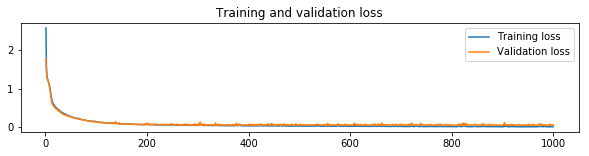

In [18]:
plt.figure(figsize=(10, 2))
plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('training-loss-gnn.pdf')
plt.show()